In [1]:
import os
import shutil
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare

In [2]:
os.makedirs("raw_dataset", exist_ok=True)

shutil.copytree('/kaggle/input/cvdl-lab-exam-2/ANTHRACNOSE-20250409T070513Z-001/ANTHRACNOSE', 'raw_dataset/ANTHRACNOSE')
shutil.copytree('/kaggle/input/cvdl-lab-exam-2/BACTERIAL CRANKER-20250409T070708Z-001/BACTERIAL CRANKER', 'raw_dataset/BACTERIAL CRANKER')
shutil.copytree('/kaggle/input/cvdl-lab-exam-2/DIEBACK-20250409T065230Z-001/DIEBACK', 'raw_dataset/DIEBACK')
shutil.copytree('/kaggle/input/cvdl-lab-exam-2/GALL MILDGE-20250409T040732Z-001/GALL MILDGE', 'raw_dataset/GALL MILDGE')
shutil.copytree('/kaggle/input/cvdl-lab-exam-2/HEALTHY-20250409T065245Z-001/HEALTHY', 'raw_dataset/HEALTHY')
shutil.copytree('/kaggle/input/cvdl-lab-exam-2/MANGO SOOTY-20250409T071331Z-001/MANGO SOOTY', 'raw_dataset/MANGO SOOTY')
shutil.copytree('/kaggle/input/cvdl-lab-exam-2/SOOTY MOULD-20250409T064124Z-001/SOOTY MOULD', 'raw_dataset/SOOTY MOULD')

'raw_dataset/SOOTY MOULD'

In [3]:
os.listdir('/kaggle/working/raw_dataset')

['GALL MILDGE',
 'BACTERIAL CRANKER',
 'ANTHRACNOSE',
 'SOOTY MOULD',
 'HEALTHY',
 'DIEBACK',
 'MANGO SOOTY']

# Pre processing

In [4]:
input_parent_dir = '/kaggle/working/raw_dataset'
output_parent_dir = '/kaggle/working/prepared_dataset'
target_size = (224, 224)

In [5]:
for class_name in os.listdir(input_parent_dir):
    class_path = os.path.join(input_parent_dir, class_name)
    if not os.path.isdir(input_parent_dir):
        continue  
    output_class_path = os.path.join(output_parent_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)
    for image_name in tqdm(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_name)
        try:
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                img = img.resize(target_size)
                img_array = np.asarray(img) / 255.0
                normalized_img = Image.fromarray((img_array * 255).astype(np.uint8))
                output_image_path = os.path.join(output_class_path, image_name)
                normalized_img.save(output_image_path)
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")

100%|██████████| 228/228 [00:44<00:00,  5.13it/s]


# VAE model

Using device: cpu


Epoch 1/10: 100%|██████████| 57/57 [05:59<00:00,  6.30s/it]


Epoch 1, Avg Loss: 28418.7885


Epoch 2/10: 100%|██████████| 57/57 [05:52<00:00,  6.18s/it]


Epoch 2, Avg Loss: 19491.6660


Epoch 3/10: 100%|██████████| 57/57 [05:59<00:00,  6.31s/it]


Epoch 3, Avg Loss: 17293.9113


Epoch 4/10: 100%|██████████| 57/57 [05:49<00:00,  6.13s/it]


Epoch 4, Avg Loss: 16011.0502


Epoch 5/10: 100%|██████████| 57/57 [05:47<00:00,  6.09s/it]


Epoch 5, Avg Loss: 15397.7294


Epoch 6/10: 100%|██████████| 57/57 [05:50<00:00,  6.15s/it]


Epoch 6, Avg Loss: 15015.9022


Epoch 7/10: 100%|██████████| 57/57 [05:48<00:00,  6.11s/it]


Epoch 7, Avg Loss: 14760.6307


Epoch 8/10: 100%|██████████| 57/57 [05:56<00:00,  6.25s/it]


Epoch 8, Avg Loss: 14333.6303


Epoch 9/10: 100%|██████████| 57/57 [05:53<00:00,  6.20s/it]


Epoch 9, Avg Loss: 14011.8812


Epoch 10/10: 100%|██████████| 57/57 [05:49<00:00,  6.13s/it]


Epoch 10, Avg Loss: 13763.8358


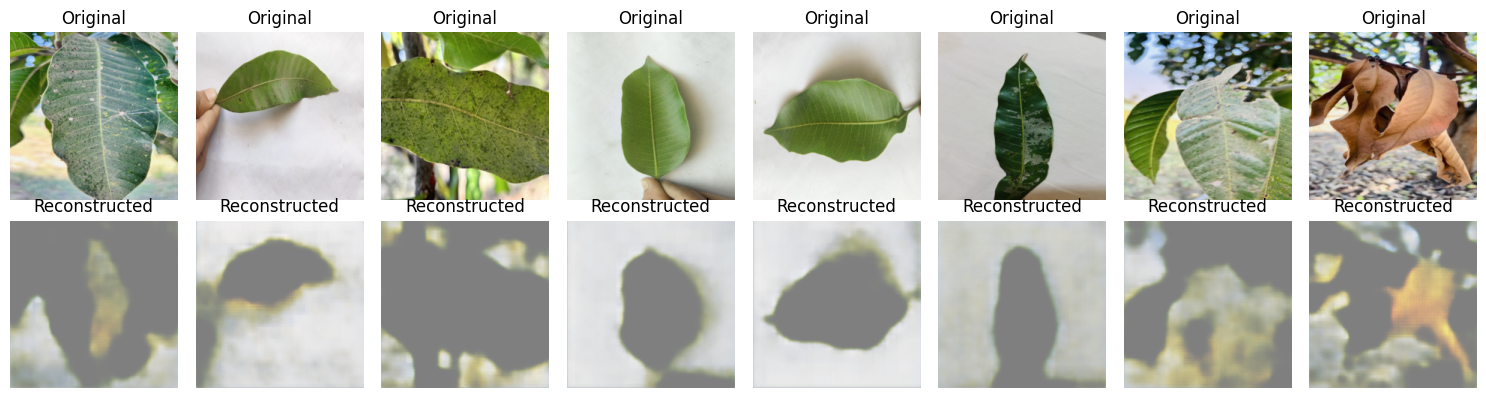

In [6]:
# import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm  

# Set device BEFORE defining model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define VAE class
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [B, 32, 112, 112]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # [B, 64, 56, 56]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # [B, 128, 28, 28]
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # [B, 256, 14, 14]
            nn.ReLU(),
            nn.Flatten(),  # [B, 256*14*14]
        )

        self.fc_mu = nn.Linear(256 * 14 * 14, latent_dim)
        self.fc_logvar = nn.Linear(256 * 14 * 14, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 14 * 14)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 14, 14)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # [B, 128, 28, 28]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [B, 64, 56, 56]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [B, 32, 112, 112]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # [B, 3, 224, 224]
            nn.Sigmoid()  # Output in [0, 1] range
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_encoded = self.encoder(x)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        z = self.reparameterize(mu, logvar)
        x_decoded = self.decoder(self.decoder_input(z))
        return x_decoded, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize all to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)     # Normalize to [-1, 1]
])

# Dataset & Dataloader
dataset = datasets.ImageFolder("raw_dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model, Optimizer
vae = VAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for batch, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = batch.to(device)
        recon_batch, mu, logvar = vae(batch)
        loss = vae.loss_function(recon_batch, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

# Evaluation: Reconstruct and display
vae.eval()
with torch.no_grad():
    sample_batch, _ = next(iter(dataloader))
    sample_batch = sample_batch.to(device)
    recon_batch, _, _ = vae(sample_batch)

    sample_batch = sample_batch.cpu()
    recon_batch = recon_batch.cpu()

    fig, ax = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        ax[0][i].imshow((sample_batch[i].permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1))  # unnormalize
        ax[0][i].set_title("Original")
        ax[0][i].axis("off")

        ax[1][i].imshow((recon_batch[i].permute(1, 2, 0) * 0.5 + 0.5).clamp(0, 1))  # unnormalize
        ax[1][i].set_title("Reconstructed")
        ax[1][i].axis("off")

    plt.tight_layout()
    plt.show()

# GAN model

Using device: cpu


Epoch 10/10: 100%|██████████| 57/57 [14:29<00:00, 15.26s/it, lossD=1.92, lossG=1.05]


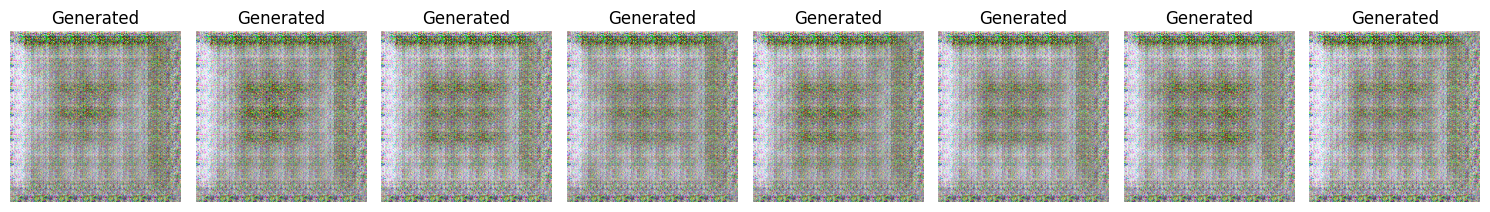

In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image dimensions
image_size = 224
channels_img = 3
z_dim = 100  # latent vector size
features_gen = 64
features_disc = 64

# Transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Normalize to [-1, 1]
])

# Dataset & DataLoader
dataset = datasets.ImageFolder("raw_dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels_img, features_disc, 4, 2, 1),  # 112x112
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_disc, features_disc * 2, 4, 2, 1),  # 56x56
            nn.BatchNorm2d(features_disc * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_disc * 2, features_disc * 4, 4, 2, 1),  # 28x28
            nn.BatchNorm2d(features_disc * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_disc * 4, features_disc * 8, 4, 2, 1),  # 14x14
            nn.BatchNorm2d(features_disc * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_disc * 8, 1, 4, 1, 0),  # 11x11 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_gen * 8, 7, 1, 0),  # [B, 512, 7, 7]
            nn.BatchNorm2d(features_gen * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(features_gen * 8, features_gen * 4, 4, 2, 1),  # 14x14
            nn.BatchNorm2d(features_gen * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(features_gen * 4, features_gen * 2, 4, 2, 1),  # 28x28
            nn.BatchNorm2d(features_gen * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(features_gen * 2, features_gen, 4, 2, 1),  # 56x56
            nn.BatchNorm2d(features_gen),
            nn.ReLU(),
            nn.ConvTranspose2d(features_gen, channels_img, 4, 4, 1),  # 224x224
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
gen = Generator().to(device)
disc = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Labels
real_label = 1
fake_label = 0

# Training loop
epochs = 10
for epoch in range(epochs):
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for real, _ in loop:
        real = real.to(device)
        batch_size = real.size(0)

        ### Train Discriminator ###
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.full_like(disc_real, real_label, device=device))

        disc_fake = disc(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.full_like(disc_fake, fake_label, device=device))

        lossD = lossD_real + lossD_fake
        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### Train Generator ###
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.full_like(output, real_label, device=device))
        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        loop.set_postfix(lossD=lossD.item(), lossG=lossG.item())

# Generate and visualize samples
gen.eval()
with torch.no_grad():
    noise = torch.randn(8, z_dim, 1, 1, device=device)
    fake_images = gen(noise).cpu()

    fig, ax = plt.subplots(1, 8, figsize=(15, 4))
    for i in range(8):
        img = fake_images[i]
        img = (img * 0.5 + 0.5).clamp(0, 1)  # Unnormalize
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].axis("off")
        ax[i].set_title("Generated")
    plt.tight_layout()
    plt.show()

# Generate images

In [8]:
import os
from torchvision.utils import save_image

# Folder path
vae_output_dir = "vae_generated_images"
os.makedirs(vae_output_dir, exist_ok=True)

# Generate 100 images
vae.eval()
with torch.no_grad():
    z = torch.randn(100, vae.latent_dim).to(device)
    generated_imgs = vae.decoder(vae.decoder_input(z)).cpu()

# Save each image
for i in range(100):
    img = (generated_imgs[i] * 0.5 + 0.5).clamp(0, 1)  # Unnormalize
    save_image(img, f"{vae_output_dir}/vae_img_{i+1:03d}.png")

In [9]:
latent_dim = 100  
# Folder path
gan_output_dir = "gan_generated_images"
os.makedirs(gan_output_dir, exist_ok=True)

# Generate 100 noise vectors
z = torch.randn(100, latent_dim, 1, 1).to(device)

gen.eval()
with torch.no_grad():
    generated_imgs = gen(z).cpu()

# Save each image
for i in range(100):
    img = (generated_imgs[i] * 0.5 + 0.5).clamp(0, 1)  # Unnormalize
    save_image(img, f"{gan_output_dir}/gan_img_{i+1:03d}.png")

# Evaluation

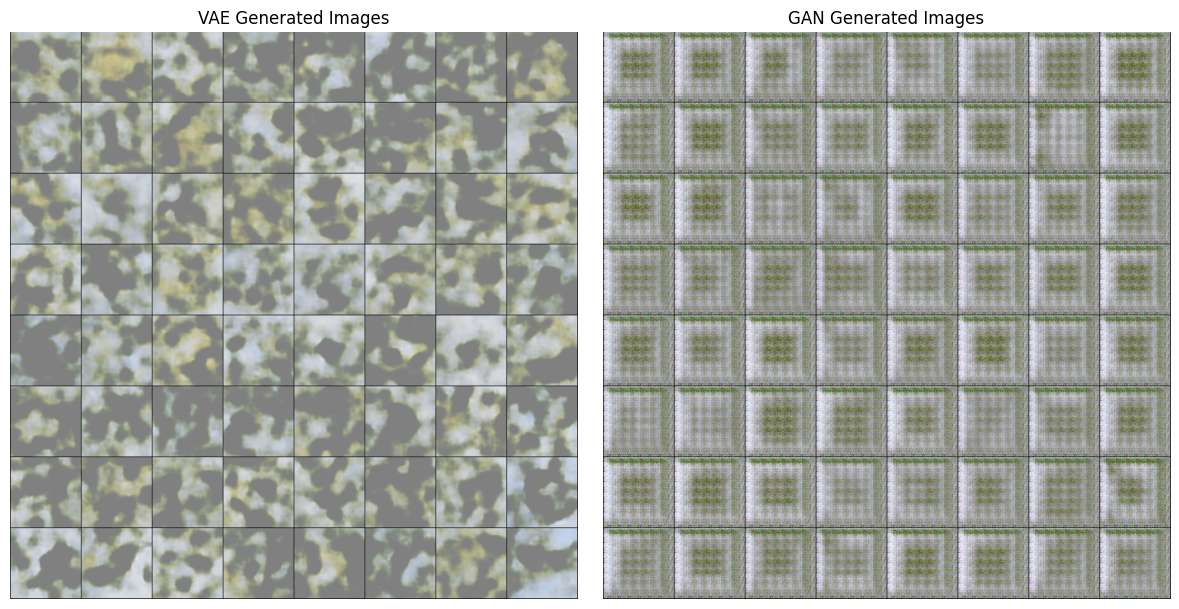

In [10]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.io import read_image
import os

def load_generated_images(folder):
    images = []
    for i in range(100):
        path = os.path.join(folder, f"{folder.split('_')[0]}_img_{i+1:03d}.png")
        if os.path.exists(path):
            img = read_image(path).float() / 255.0  # normalize to [0, 1]
            images.append(img)
    return torch.stack(images[:64])  # Show only 64 for grid

vae_imgs = load_generated_images("vae_generated_images")
gan_imgs = load_generated_images("gan_generated_images")

# Plot both
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(vutils.make_grid(vae_imgs, nrow=8).permute(1, 2, 0))
axs[0].set_title("VAE Generated Images")
axs[0].axis("off")

axs[1].imshow(vutils.make_grid(gan_imgs, nrow=8).permute(1, 2, 0))
axs[1].set_title("GAN Generated Images")
axs[1].axis("off")

plt.tight_layout()
plt.show()

### SSIM

In [11]:
import os
import torch
from torchvision.io import read_image

def load_all_images(folder, max_images=100):
    images = []
    valid_exts = ('.png', '.jpg', '.jpeg')
    files = [f for f in os.listdir(folder) if f.lower().endswith(valid_exts)]

    for filename in files[:max_images]:
        path = os.path.join(folder, filename)
        img = read_image(path).float() / 255.0
        images.append(img)

    if not images:
        raise FileNotFoundError(f"No valid images found in {folder}")
    
    return torch.stack(images)

real_images = load_all_images("/kaggle/working/prepared_dataset/DIEBACK")

In [12]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ✅ Unnormalize if needed (optional)
vae_imgs = (vae_imgs + 1) / 2
gan_imgs = (gan_imgs + 1) / 2
real_imgs = (real_images + 1) / 2  # real_images should be a Tensor

# ✅ Resize all to (32, 32)
vae_imgs_resized = F.interpolate(vae_imgs, size=(32, 32), mode='bilinear', align_corners=False)
gan_imgs_resized = F.interpolate(gan_imgs, size=(32, 32), mode='bilinear', align_corners=False)
real_imgs_resized = F.interpolate(real_imgs[:100], size=(32, 32), mode='bilinear', align_corners=False)

# ✅ SSIM computation
def compute_mean_ssim(generated, real):
    scores = []
    for gen, real in zip(generated, real):
        gen_np = gen.permute(1, 2, 0).cpu().numpy()
        real_np = real.permute(1, 2, 0).cpu().numpy()
        s = ssim(gen_np, real_np, channel_axis=-1, data_range=1.0)
        scores.append(s)
    return np.mean(scores)

# ✅ Run SSIM comparisons
print("Mean SSIM (VAE vs Real):", compute_mean_ssim(vae_imgs_resized, real_imgs_resized))
print("Mean SSIM (GAN vs Real):", compute_mean_ssim(gan_imgs_resized, real_imgs_resized))

Mean SSIM (VAE vs Real): 0.13014556
Mean SSIM (GAN vs Real): 0.12566918


### FID

In [13]:
! pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attempting

In [14]:
import os
import numpy as np
from PIL import Image
import torch

def save_images(imgs, folder):
    os.makedirs(folder, exist_ok=True)
    imgs = (imgs + 1) / 2  # Normalize from [-1, 1] to [0, 1]
    imgs = imgs.mul(255).clamp(0, 255).byte()  # Convert to [0, 255] and uint8
    imgs = imgs.permute(0, 2, 3, 1).cpu().numpy()  # CHW -> HWC and to numpy

    for i, img in enumerate(imgs):
        img_pil = Image.fromarray(img)
        img_pil.save(f"{folder}/img_{i}.png")

# Save real, VAE, and GAN images
save_images(real_images[:100], "real")
save_images(vae_imgs[:100], "vae")
save_images(gan_imgs[:100], "gan")

In [15]:
from pytorch_fid import fid_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fid_vae = fid_score.calculate_fid_given_paths(
    paths=["real", "vae"],
    batch_size=50,
    device=device,
    dims=2048
)

fid_gan = fid_score.calculate_fid_given_paths(
    paths=["real", "gan"],
    batch_size=50,
    device=device,
    dims=2048
)

print(f"FID (VAE vs Real): {fid_vae}")
print(f"FID (GAN vs Real): {fid_gan}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 138MB/s]


100%|██████████| 2/2 [00:15<00:00,  7.61s/it]


100%|██████████| 2/2 [00:15<00:00,  7.86s/it]


FID (VAE vs Real): 396.65321644522686
FID (GAN vs Real): 453.1865951274785
